# Lidar Particle Filter

First we will draw some features of a map.  These are essentially a sparse collection of points representing, say, walls in a room and other static obstacles in the room.  Basically we just want to make a collection of points that define a map of our known universe.  Since one simple thing to mimic is a room with straight walls and periodic known points on the boundary, let's use some helpers to generate these and then extend it to work with rectangles in general. This way we can fairly easily generate a collection of points that is representative of, say, a room with some simple objects like furniture in it.  While in the real world the map may have ambiguity (noise) associated with the known points, for the moment we will work on localizing with perfectly known points.

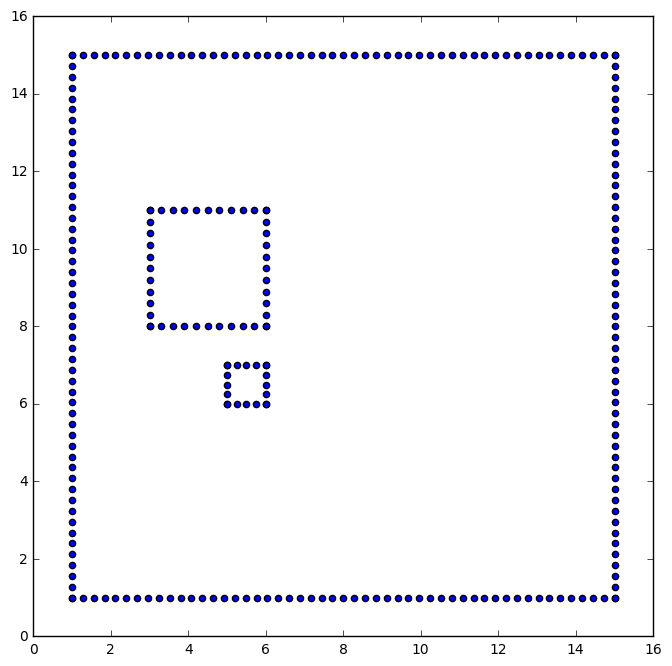

In [72]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class Room:

    def map_range_x(self, start, stop, number, y):
        return [[start + (stop - start) * i / number, y] for i in range(number + 1)]

    def map_range_y(self, start, stop, number, x):
        return [[x, start + (stop - start) * i / number] for i in range(number + 1)]

    def map_square(self, top_left, bottom_right, points):
        res  = self.map_range_y(top_left[1], bottom_right[1], points, top_left[0])
        res += self.map_range_y(top_left[1], bottom_right[1], points, bottom_right[0])
        res += self.map_range_x(top_left[0], bottom_right[0], points, top_left[1])
        res += self.map_range_x(top_left[0], bottom_right[0], points, bottom_right[1])
        return res

    def make_room(self):
        walls = self.map_square((1.,1.), (15.,15.), 50)
        table = self.map_square((3.,8.), (6.,11.), 10)
        chair = self.map_square((5.,6.), (6.,7.), 4)
        return walls + table + chair


# Set the plot size        
plt.figure(figsize=(8,8))    
    
# Build the room map points
r = Room()
room = r.make_room()

# Unzip the x-y coordinates
x, y = zip(*room)

# Plot the points
plt.scatter(x, y)    
plt.show()

Next we will position a candidate observer in room and simulate a directional sweep of the room in the way that would generate something similar to what a lidar would produce.  This will result in data that is tuples of angle and distance.  The way this is done is to first compute the distance and angle from the robot location to each point room point.  For each discrete angle in our simulated lidar sweep, we will find the points that are within that sweep and record the closest one.  It is not a particularly performant way of accomplishing the task, but it is adequate for working on the process.  We will also plot the distance points so that we can visualize what the lidar would appear as and confirm that it is sensible given the parameters we have set.

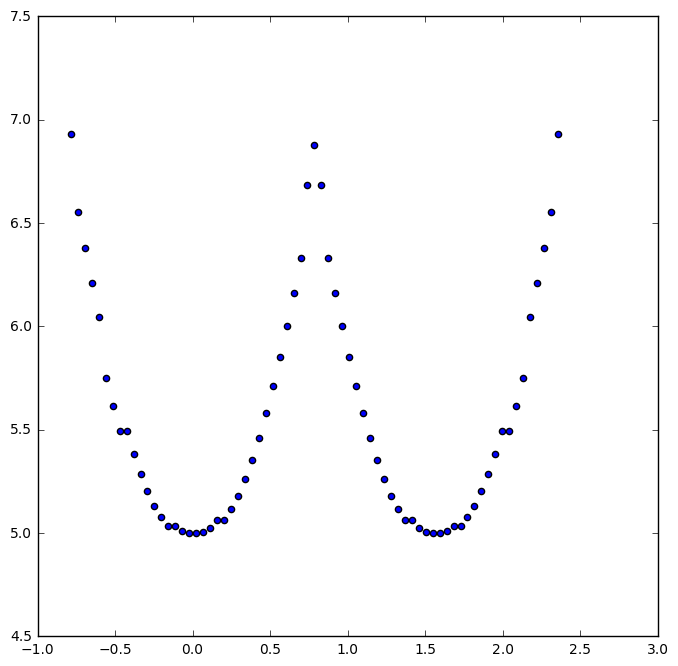

In [73]:
class RoomView:

    def __init__(self, points, angle_sweep, sweep_number):
        self.points = points
        self.angle_sweep = angle_sweep
        self.sweep_number = sweep_number
        
    def angle_range(self, center):
        delta = self.angle_sweep
        n = self.sweep_number
        return [(center - delta) + 2 * delta * i / n for i in range(2 * n + 1)]

    def angle_and_distance(self, robot_location, point_location):
        (rx, ry) = robot_location
        (px, py) = point_location
        dx = px - rx
        dy = py - ry
        distance = math.sqrt(dx**2 + dy**2)
        angle = math.atan2(dy, dx)
        return (angle, distance)

    def closest_point_in_swath(self, min_angle, max_angle, robot_location):
        pts = []
        for p in self.points:
            angle, distance = self.angle_and_distance(robot_location, p)
            if angle > min_angle and angle < max_angle:
                pts.append((angle, distance))
        pts = sorted(pts, key = lambda x: x[1])
        if len(pts) > 0:
            return pts[0]
        return (None, None)

    def lidar_points(self, robot_location, robot_angle):
        pts = []
        angles = self.angle_range(robot_angle)
        delta = 2 * self.angle_sweep / self.sweep_number
        for a in angles:
            min_a = a - delta
            max_a = a + delta
            _, distance = self.closest_point_in_swath(min_a, max_a, robot_location)
            if distance is not None:
                pts.append((a, distance))
        return pts
        

# Set the plot size        
plt.figure(figsize=(8,8))

# Set up a room view with a pi/4 half-angle aperture and 15 angle slices on each side
rv = RoomView(room, math.pi/4, 35)

# Get the lidar points for a robot facing due East
p = rv.lidar_points(robot_location, 0)

# Unzip the angle-distance tuple
a, d = zip(*p)

# Plot as a scatter plot
plt.scatter(a, d)
plt.show()